In [62]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
from shapely.geometry import MultiPoint, Polygon, Point, LineString
from shapely.ops import unary_union
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
import pyproj
from scipy import spatial
import random
import os
import json

# sample geographical points for Copenhagen
This work is inspired by this paper --> https://arxiv.org/abs/2105.01764.
We extensively make use of their code from --> https://github.com/stanford-policylab/surveilling-surveillance/blob/master/streetview/sample.py

In [63]:
# load shapes for danish kommuner (regions)
shapes = json.load(open('data/denmark-kommuner.geojson'))

In [58]:
# find geocoordinates for the capital copenhagen (CPH)
cph = []
for s in shapes['features']:
    if s['properties']['KOMNAVN'] == 'København':
        cph.append(Polygon(s['geometry']['coordinates'][0]))
# take the unary union to also include Frederiksberg (which is a city inside the capital)
cph = unary_union(cph)

In [59]:
# download street network from OSM for all road segments in the polygon
G = ox.graph_from_polygon(cph,network_type='drive')

# extract position for nodes (intersections)
pos = dict(G.nodes(data = True))

__plot map - not necessary to run for below code to work__

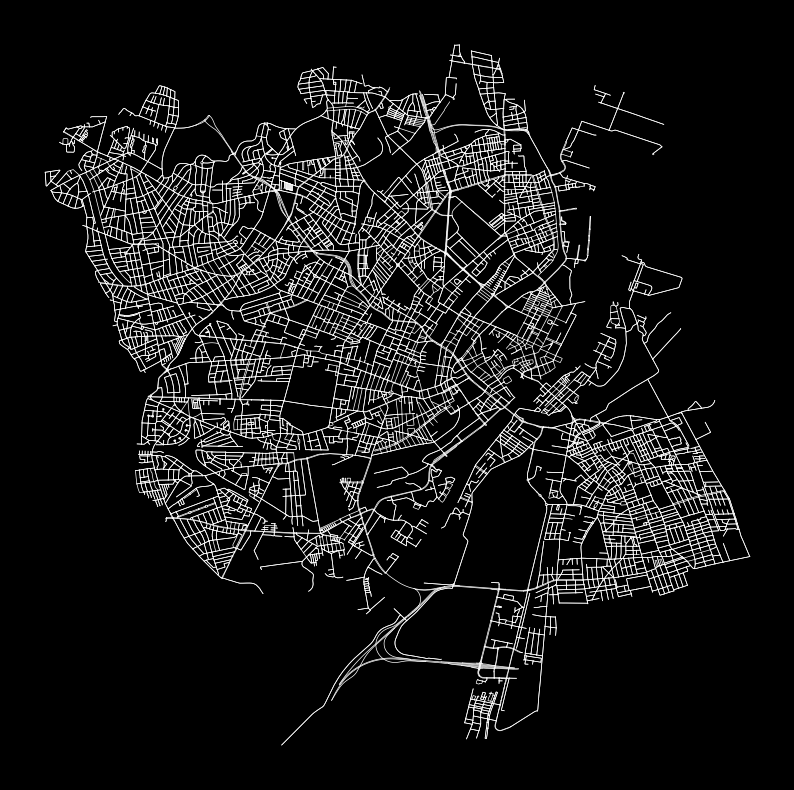

In [64]:
# draw map
plt.figure(figsize=(10,10))
plt.style.use('dark_background')
for segment in G.edges(data=True):
    if 'geometry' in segment[2]:
        x,y = segment[2]['geometry'].xy
        plt.plot(x,y,color='white',lw=0.5)
    else:
        i,j = segment[:2]
        xi = pos[i]['x']; yi = pos[i]['y']
        xj = pos[j]['x']; yj = pos[j]['y']
        plt.plot([xi,xj],[yi,yj],color='white',lw=0.5)
plt.axis('off')
plt.savefig('plots/copenhagen-roads.png',dpi=300)
plt.show()

# sample points from street network

### First sample roads, then sample points from roads

In [65]:
def get_pos_for_node(node):
    return Point(pos[node]['x'], pos[node]['y'])

def sample_points(n):
    # first transform edges to dataframe
    df = []
    for i,j,info_ in list(G.edges(data=True)):

        # if geometry exists for road (i.e. its not just a straight line)
        if 'geometry' in info_:
            #df.append((i,j,get_pos_for_node(i),get_pos_for_node(j),info_['length'],info_.get('geometry','None')))
            df.append((i,j,info_['length'],info_['geometry']))
        # if its a straight line we need to add geometry
        else:
            df.append((i,j,info_['length'],LineString([get_pos_for_node(i),get_pos_for_node(j)])))
    df = pd.DataFrame(df, columns = ['source','target','length','geometry'])

    # number of edges/roads
    m = df.shape[0]
    # total sum of road length
    total_length = sum(df['length'])
    # length normalized
    df['normalized_length'] = df['length'].div(total_length)

    # select random roads, weighted according to their length
    indices = np.random.choice(range(m),size=n, p=df['normalized_length'])
    
    # define geodesic distance function - to be used for finding road bearings
    geodesic = pyproj.Geod(ellps='WGS84')

    # use tqdm to print progress
    pbar = tqdm(total=n)
    # store data in rows
    rows = []
    
    # sample n points from road segments
    i = 0
    while i < n:
        # unpack random row/road segment
        index = indices[i]
        row = df.iloc[index]
        line = row['geometry']
        # pick a random place on the segment
        delta = np.random.rand() * line.length
        # find the coordinates this corresponds to
        point = line.interpolate(delta)
        lat = point.y
        lon = point.x

        # update counters
        i += 1
        pbar.update(1)
        
        # do start and end of point to calculate heading
        start = line.interpolate(delta*0.9)
        end = line.interpolate(min(line.length, delta*1.1))
        # find heading using the geodesic function
        fwd_azimuth,back_azimuth,_ = geodesic.inv(start.x, start.y, end.x, end.y)  #geodesic.inv(start.y, start.x, end.y, end.x)
        
        # store in rows
        rows.append({"lat": lat,
                     "lon": lon,
                     "id": i,
                     "heading": fwd_azimuth,
                     "delta": delta})
    
    # stop the progress bar
    pbar.close()

    # return samples points in dataframe
    return pd.DataFrame(rows)

In [67]:
points = sample_points(150000)

100%|██████████| 150000/150000 [00:19<00:00, 7765.30it/s]


__plot sampled points__

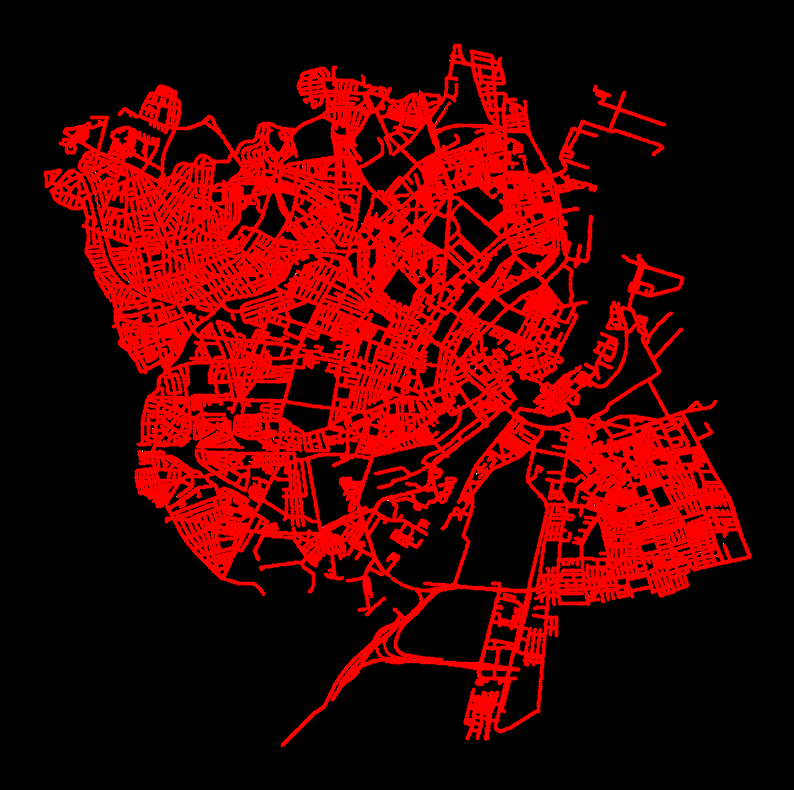

In [68]:
# draw map
plt.figure(figsize=(10,10))
plt.style.use('dark_background')
# draw road segments
for segment in G.edges(data=True):
    if 'geometry' in segment[2]:
        x,y = segment[2]['geometry'].xy
        plt.plot(x,y,color='white',lw=0.5)
    else:
        i,j = segment[:2]
        xi = pos[i]['x']; yi = pos[i]['y']
        xj = pos[j]['x']; yj = pos[j]['y']
        plt.plot([xi,xj],[yi,yj],color='white',lw=0.5)
# plot samples points
plt.scatter(points['lon'],points['lat'],s=2,color='red',zorder=4)
        
plt.axis('off')
plt.savefig('plots/copenhagen-roads-with-150k-sampled-points.png',dpi=300)
plt.show()

# clean up points
Remove points which are too close to each other - i.e. less than 7 meters (somewhat arbitrarily set)

In [15]:
# create transformation to transform from GPS (lat,lon) coordinates to UTM coordinates (i.e. given in meters)
transformation = pyproj.Proj(proj='utm', zone=33, ellps='WGS84')

# transform datapoints
x,y = transformation(points['lon'],points['lat'])

# build spatial tree
tree = spatial.KDTree(np.array((x,y)).T)

In [16]:
# query tree
candidates_for_deletion = set()
# iterate over points
for i in range(points.shape[0]):
    # if point has not already been flaged for deletion
    if i not in candidates_for_deletion:
        # fidn nearby points
        nearby = tree.query_ball_point((x[i],y[i]),r=7)
        # if there is more than the point itself 
        if len(nearby) > 1:
            # iterate over nearby points
            for j in nearby:
                # if not the point itself
                if j!=i:
                    # flag for removal
                    candidates_for_deletion.add(j)

In [17]:
# remove close points
points = points[~points['id'].isin(candidates_for_deletion)]

# save sampled points to csv
points.to_csv('data/sampled-points-150k.csv',index=False)